In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report

In [ ]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

In [9]:
from src.config.loader import Config
from src.utils.data_loader import get_data_loaders
from src.models import MLP, LogisticRegression
from src.training.trainer import Trainer
from src.evaluation.eval_metrics import calculate_metrics
from src.evaluation.eval_plotting import Plotter

config_path = os.path.join(project_root, 'src/config/config.yaml')
config = Config(config_path)

print(f"Model: {config.model['type']}")
print(f"Epochs: {config.training['epochs']}")
print(f"Learning Rate: {config.training['learning_rate']}")
print(f"Batch Size: {config.training['batch_size']}")

Model: mlp
Epochs: 50
Learning Rate: 0.001
Batch Size: 32


In [ ]:
os.chdir(project_root)

from src.utils.data_generator import generate_synthetic_mutation_data

data_path = 'data/processed/feature_matrix.csv'
generate_synthetic_mutation_data(
    n_samples=2000,
    output_path=data_path,
    include_labels=True,
    random_seed=42
)

In [ ]:
train_loader, val_loader, test_loader, input_dim = get_data_loaders(config)

print(f"Input Features: {input_dim}")
print(f"Train Samples: {len(train_loader.dataset)}")
print(f"Validation Samples: {len(val_loader.dataset)}")
print(f"Test Samples: {len(test_loader.dataset)}")

In [ ]:
model = MLP(
    input_dim=input_dim,
    hidden_layers=config.model['mlp']['hidden_layers'],
    dropout=config.model['mlp']['dropout']
).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=config.training['learning_rate'])

print(f"Model Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(model)

In [10]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    config=config,
    optimizer=optimizer,
    criterion=criterion,
    device=device
)

print("Starting training with existing Trainer architecture...")
history = trainer.train()

Starting training with existing Trainer architecture...
Starting training for 50 epochs...
Epoch 1/50 | Train Loss: 0.6625 | Val Loss: 0.6300 | Val AUC: 0.6029 | Time: 5.71s
Epoch 2/50 | Train Loss: 0.6496 | Val Loss: 0.6172 | Val AUC: 0.5978 | Time: 0.21s
Epoch 3/50 | Train Loss: 0.6407 | Val Loss: 0.6134 | Val AUC: 0.5909 | Time: 0.16s
Epoch 4/50 | Train Loss: 0.6295 | Val Loss: 0.6120 | Val AUC: 0.5849 | Time: 0.15s
Epoch 5/50 | Train Loss: 0.6340 | Val Loss: 0.6100 | Val AUC: 0.5909 | Time: 0.18s
Epoch 6/50 | Train Loss: 0.6314 | Val Loss: 0.6125 | Val AUC: 0.5829 | Time: 0.17s
Epoch 7/50 | Train Loss: 0.6278 | Val Loss: 0.6107 | Val AUC: 0.5872 | Time: 0.21s
Epoch 8/50 | Train Loss: 0.6297 | Val Loss: 0.6102 | Val AUC: 0.5908 | Time: 0.15s
Epoch 9/50 | Train Loss: 0.6276 | Val Loss: 0.6112 | Val AUC: 0.5870 | Time: 0.17s
Epoch 10/50 | Train Loss: 0.6252 | Val Loss: 0.6099 | Val AUC: 0.5884 | Time: 0.13s
Epoch 11/50 | Train Loss: 0.6273 | Val Loss: 0.6102 | Val AUC: 0.5840 | Time: 

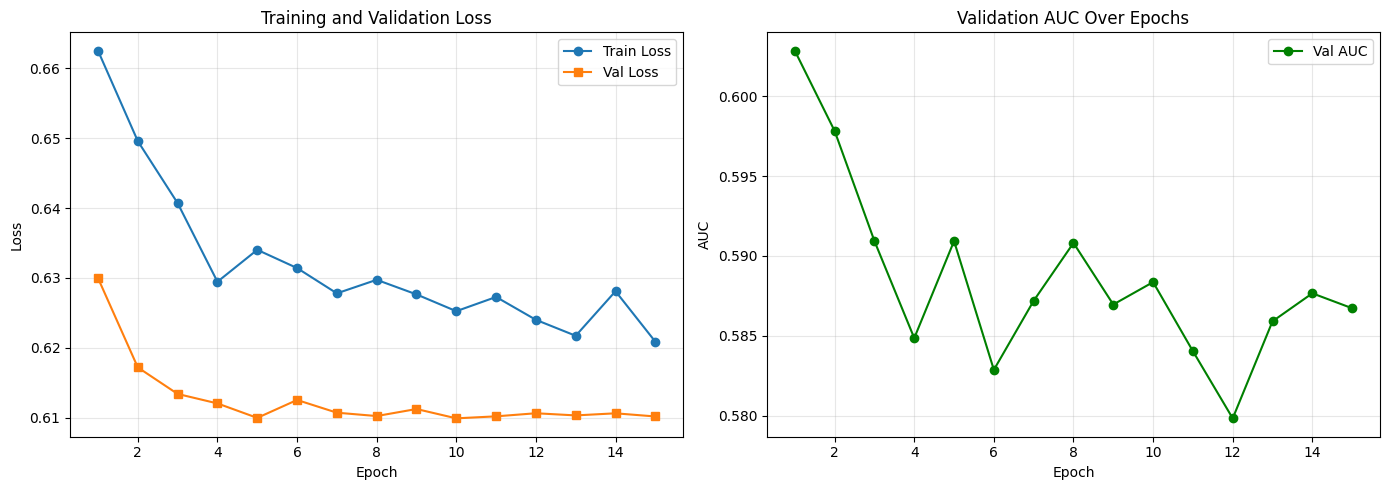

In [11]:
train_losses = history['train_loss']
val_losses = history['val_loss']
epochs_trained = len(train_losses)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, epochs_trained+1), train_losses, label='Train Loss', marker='o')
axes[0].plot(range(1, epochs_trained+1), val_losses, label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

val_aucs = [m['auc'] for m in history['val_metrics']]
axes[1].plot(range(1, epochs_trained+1), val_aucs, label='Val AUC', marker='o', color='green')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('AUC')
axes[1].set_title('Validation AUC Over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
model.eval()
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        probs = torch.sigmoid(outputs).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        
        all_probs.extend(probs.flatten())
        all_preds.extend(preds.flatten())
        all_labels.extend(y_batch.numpy())

all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

test_acc = (all_preds == all_labels).mean()
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.6182


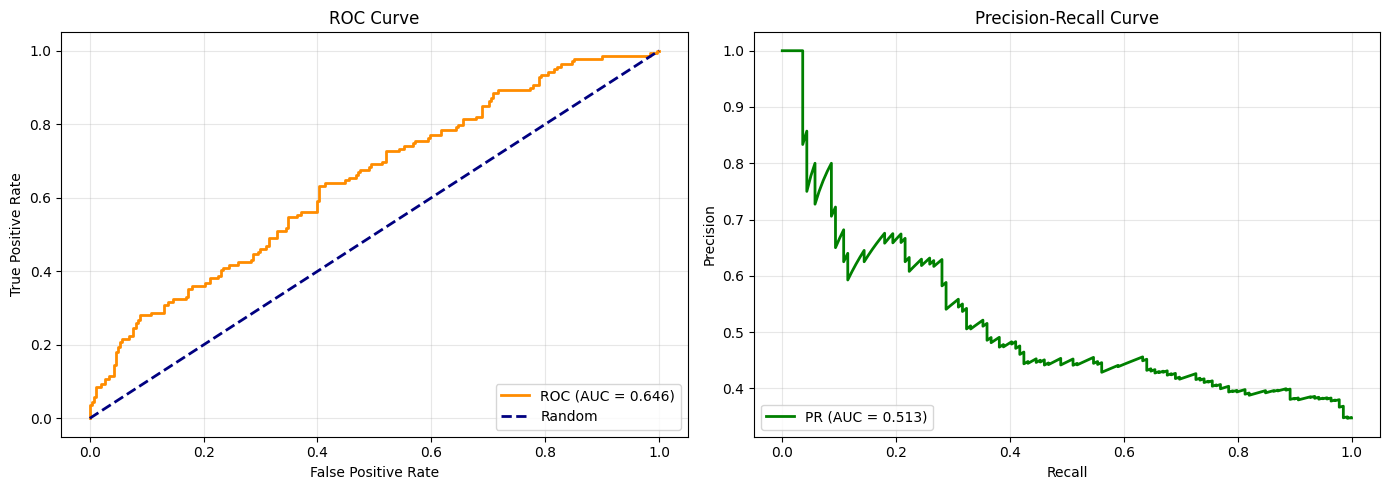

ROC-AUC: 0.6457
PR-AUC: 0.5130


In [13]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

precision, recall, _ = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall, precision)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

axes[1].plot(recall, precision, color='green', lw=2, label=f'PR (AUC = {pr_auc:.3f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend(loc='lower left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")

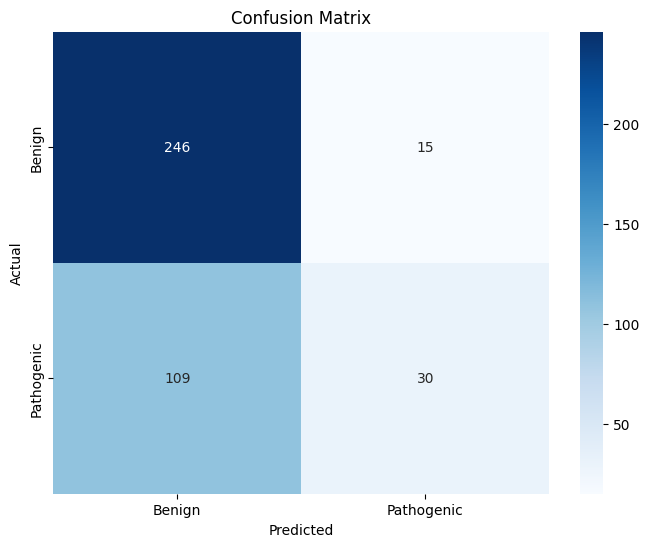

True Negatives: 246
False Positives: 15
False Negatives: 109
True Positives: 30
Sensitivity (Recall): 0.2158
Specificity: 0.9425


In [14]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Benign', 'Pathogenic'], 
            yticklabels=['Benign', 'Pathogenic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")
print(f"Sensitivity (Recall): {tp/(tp+fn):.4f}")
print(f"Specificity: {tn/(tn+fp):.4f}")

In [15]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, 
                          target_names=['Benign', 'Pathogenic'],
                          digits=4))

Classification Report:
              precision    recall  f1-score   support

      Benign     0.6930    0.9425    0.7987       261
  Pathogenic     0.6667    0.2158    0.3261       139

    accuracy                         0.6900       400
   macro avg     0.6798    0.5792    0.5624       400
weighted avg     0.6838    0.6900    0.6345       400



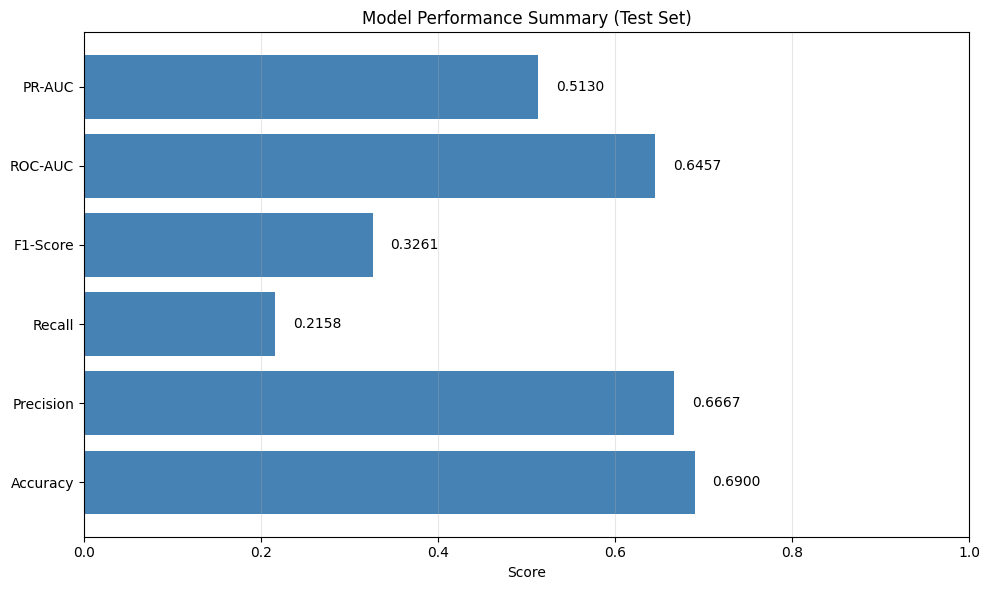


Test Set Results:
   Metric    Value
 Accuracy 0.690000
Precision 0.666667
   Recall 0.215827
 F1-Score 0.326087
  ROC-AUC 0.645745
   PR-AUC 0.513046


In [16]:
test_metrics = calculate_metrics(all_labels, all_probs)

results_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC'],
    'Value': [
        test_metrics['accuracy'],
        test_metrics['precision'],
        test_metrics['recall'],
        test_metrics['f1'],
        roc_auc,
        pr_auc
    ]
})

plt.figure(figsize=(10, 6))
bars = plt.barh(results_df['Metric'], results_df['Value'], color='steelblue')
plt.xlabel('Score')
plt.title('Model Performance Summary (Test Set)')
plt.xlim(0, 1)
plt.grid(True, alpha=0.3, axis='x')

for i, (metric, value) in enumerate(zip(results_df['Metric'], results_df['Value'])):
    plt.text(value + 0.02, i, f'{value:.4f}', va='center')

plt.tight_layout()
plt.show()

print("\nTest Set Results:")
print(results_df.to_string(index=False))

In [17]:
checkpoint_dir = config.training['checkpoint_dir']
print(f"Model checkpoints saved to: {checkpoint_dir}")
print(f"  - best_model.pth (best validation loss)")
print(f"  - final_model.pth (final epoch)")

log_dir = config.training['log_dir']
print(f"\nTraining history saved to: {log_dir}/training_history.json")

print("\n✓ Training Complete!")

Model checkpoints saved to: reports/results/checkpoints
  - best_model.pth (best validation loss)
  - final_model.pth (final epoch)

Training history saved to: reports/results/logs/training_history.json

✓ Training Complete!
